# T3

# policy gradient

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch 
import torch.nn as nn
import numpy as np
import gym
from torch.optim import AdamW

**1. Parametrización de política**

In [3]:
class Policy(nn.Module):
    
    def __init__(self, dim_states, dim_actions, continuous_control):
        super(Policy, self).__init__()
        # MLP, fully connected layers, ReLU activations, linear ouput activation
        # dim_states -> 64 -> 64 -> dim_actions

        self.layers = nn.Sequential(
            nn.Linear(dim_states, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, dim_actions)
        )
        
        if continuous_control:
            # trainable parameter
            self.log_std = nn.Parameter(torch.zeros(1, dim_actions))


    def forward(self, input):

        # tensor format
        if isinstance(input, torch.Tensor):
            input=input
            
        else:
            input = torch.from_numpy(input).unsqueeze(dim=0).float()
            
        value = self.layers(input)
        
        return value


In [4]:
env = gym.make('Pendulum-v1')
dim_states = env.observation_space.shape[0]
continuous_control = isinstance(env.action_space, gym.spaces.Box)
dim_actions = env.action_space.shape[0] if continuous_control else env.action_space.n
print(dim_states, dim_actions,continuous_control)

3 1 True


In [5]:
RN_policy= Policy(dim_states, dim_actions,continuous_control)
RN_policy

Policy(
  (layers): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [6]:
RN_policy.log_std

Parameter containing:
tensor([[0.]], requires_grad=True)

In [7]:
s_t=env.reset()
s_t

array([ 0.06567705, -0.99784094,  0.7657148 ], dtype=float32)

In [8]:
action=RN_policy(s_t)
action

tensor([[0.1421]], grad_fn=<AddmmBackward>)

In [9]:
class PolicyGradients:
    
    def __init__(self, dim_states, dim_actions, lr, gamma, 
                 continuous_control=False, reward_to_go=False, use_baseline=False):
        
        self._learning_rate = lr
        self._gamma = gamma
        
        self._dim_states = dim_states
        self._dim_actions = dim_actions

        self._continuous_control = continuous_control
        self._use_reward_to_go = reward_to_go
        self._use_baseline = use_baseline

        self._policy = Policy(self._dim_states, self._dim_actions, self._continuous_control)
        # Adam optimizer
        self._optimizer = AdamW(self._policy.parameters(), lr=self._learning_rate)

        self._select_action = self._select_action_continuous if self._continuous_control else self._select_action_discrete
        self._compute_loss = self._compute_loss_continuous if self._continuous_control else self._compute_loss_discrete


    def select_action(self, observation):
        return self._select_action(observation)
        

    def _select_action_discrete(self, observation):
        # sample from categorical distribution
        RN_policy=self._policy 
        logits=RN_policy(observation)

        # Probabilidad de cada acción
        probs = torch.softmax(logits, dim=-1)

        # Distribución de probabilidad categorica
        dist = torch.distributions.Categorical(probs)

        # Sample de acción
        action = dist.sample()#.item()
     
        return action


    def _select_action_continuous(self, observation):
        # sample from normal distribution
        # use the log std trainable parameter

        # RN
        RN_policy=self._policy

        # Parametro log std de la RN
        log_std=RN_policy.log_std
        std = torch.exp(log_std)

        # Politica dada la observación (Representa el promedio de la distribución normal que muestrea acciones)
        policy=RN_policy(observation)
        
        # Distribución normal de parametros mean y std, esta se utiliza para muestrear acciones de modo de tal de explorar el espacio de acciones
        dist = torch.distributions.Normal(policy, std)

        # sample de acción
        action = dist.sample()
        
        # Asegurarse de que las acciones están dentro del rango [-1, 1]
        #action = torch.tanh(action)
        
        return action
            

    def update(self, observation_batch, action_batch, advantage_batch):
        # update the policy here
        # you should use self._compute_loss 

        pass
    

    def _compute_loss_discrete(self, observation_batch, action_batch, advantage_batch):
        # use negative logprobs * advantages
        pass


    def _compute_loss_continuous(self, observation_batch, action_batch, advantage_batch):
        # use negative logprobs * advantages
        pass

    
    def estimate_returns(self, rollouts_rew):
        estimated_returns = []
        for rollout_rew in rollouts_rew:
                
            if self._use_reward_to_go:
                # only for part 2
                estimated_return = None
            else:
                estimated_return = None
            
            estimated_returns = np.concatenate([estimated_returns, estimated_return])

        if self._use_baseline:
            # only for part 2
            average_return_baseline = None
            # Use the baseline:
            #estimated_returns -= average_return_baseline

        return np.array(estimated_returns, dtype=np.float32)


    # It may be useful to discount the rewards using an auxiliary function [optional]
    def _discount_rewards(self, rewards):
        pass


**2. Muestreo de trayectorias**

In [10]:
import gym
import time
import datetime
import csv

import numpy as np

import matplotlib.pyplot as plt

#from policy_gradients import PolicyGradients


def perform_single_rollout(env, agent, episode_nb, render=False):

    # Modify this function to return a tuple of numpy arrays containing (observations, actions, rewards).
    # (np.array(obs), np.array(acs), np.array(rws))
    # np.array(obs) -> shape: (time_steps, nb_obs)
    # np.array(acs) -> shape: (time_steps, nb_acs) if actions are continuous, (time_steps,) if actions are discrete
    # np.array(rws) -> shape: (time_steps,)

    obs_list = []
    action_list = []
    reward_list = []

    ob_t = env.reset()
    
    done = False
    episode_reward = 0
    nb_steps = 0

    while not done:
        
        if render:
            env.render()
            time.sleep(1. / 60)

        #action = agent.select_action(ob_t)
        
        action = agent.select_action(ob_t)
    
        #print(action)

        try:    
            ob_t1, reward, done, _ = env.step(action)

        except:
            ob_t1, reward, done, _ = env.step(action.item())


        obs_list.append(ob_t1)
        action_list.append(action)
        reward_list.append(reward)

        ob_t = np.squeeze(ob_t1) # <-- may not be needed depending on gym version

        episode_reward += reward
        
        nb_steps += 1

        if done:
            print(f"Largo del episodio {nb_steps}")
            obs_array = np.array(obs_list)
            action_array = np.array(action_list)
            reward_array = np.array(reward_list)

            return obs_array, action_array, reward_array
    #return None

def sample_rollouts(env, agent, training_iter, min_batch_steps):

    sampled_rollouts = []
    total_nb_steps = 0
    episode_nb = 0
    
    while total_nb_steps < min_batch_steps:

        episode_nb += 1
        #render = training_iter%10 == 0 and len(sampled_rollouts) == 0 # Change training_iter%10 to any number you want
        render=False
        # Use perform_single_rollout to get data 
        # Uncomment once perform_single_rollout works.
        # Return sampled_rollouts
       
        sample_rollout = perform_single_rollout(env, agent, episode_nb, render=render)
        total_nb_steps += len(sample_rollout[0])

        sampled_rollouts.append(sample_rollout)
        
    return sampled_rollouts




In [11]:
env = gym.make('Pendulum-v1')

dim_states = env.observation_space.shape[0]

continuous_control = isinstance(env.action_space, gym.spaces.Box)
dim_actions = env.action_space.shape[0] if continuous_control else env.action_space.n

policy_gradients_agent = PolicyGradients(dim_states=dim_states, 
                                             dim_actions=dim_actions, 
                                             lr=0.005,
                                             gamma=0.99,
                                             continuous_control=continuous_control,
                                             reward_to_go=False,
                                             use_baseline=False)



In [12]:
# Rollout
x1=perform_single_rollout(env, policy_gradients_agent, 1000, render=False)
print(x1[0].shape)
print(x1[1].shape)
print(x1[2].shape)

Largo del episodio 200
(200, 3)
(200,)
(200,)


**El número de filas de las observaciones es igual con el largo del episodio, por lo que se concluye el correcto funcionamiento de la función.**

In [53]:
# Sample rollouts
x2=sample_rollouts(env, policy_gradients_agent, 1000, 5000)

Largo del episodio 200
Largo del episodio 200
Largo del episodio 200
Largo del episodio 200
Largo del episodio 200
Largo del episodio 200
Largo del episodio 200
Largo del episodio 200
Largo del episodio 200
Largo del episodio 200
Largo del episodio 200
Largo del episodio 200
Largo del episodio 200
Largo del episodio 200
Largo del episodio 200
Largo del episodio 200
Largo del episodio 200
Largo del episodio 200
Largo del episodio 200
Largo del episodio 200
Largo del episodio 200
Largo del episodio 200
Largo del episodio 200
Largo del episodio 200
Largo del episodio 200


In [54]:
sampled_obs = np.concatenate([x2[i][0] for i in range(len(x2))])
sampled_action = np.concatenate([x2[i][1] for i in range(len(x2))])
sampled_reward = np.concatenate([x2[i][2] for i in range(len(x2))])
print(sampled_obs.shape)
print(sampled_action.shape)
print(sampled_reward.shape)

(5000, 3)
(5000,)
(5000,)


**El largo del registro de sample rollout es al menos el número de sample mini batch, se concluye que la función funciona.**

In [108]:
env = gym.make('CartPole-v1')

dim_states = env.observation_space.shape[0]

continuous_control = isinstance(env.action_space, gym.spaces.Box)
dim_actions = env.action_space.shape[0] if continuous_control else env.action_space.n

policy_gradients_agent = PolicyGradients(dim_states=dim_states, 
                                             dim_actions=dim_actions, 
                                             lr=0.005,
                                             gamma=0.99,
                                             continuous_control=continuous_control,
                                             reward_to_go=False,
                                             use_baseline=False)


In [56]:
# Rollout
x1=perform_single_rollout(env, policy_gradients_agent, 1000, render=False)
print(x1[0].shape)
print(x1[1].shape)
print(x1[2].shape)

Largo del episodio 22
(22, 4)
(22,)
(22,)


**El número de filas de las observaciones es igual con el largo del episodio, por lo que se concluye el correcto funcionamiento de la función.**

In [57]:
# Sample rollouts
x2=sample_rollouts(env, policy_gradients_agent, 1000, 5000)

Largo del episodio 21
Largo del episodio 11
Largo del episodio 25
Largo del episodio 34
Largo del episodio 23
Largo del episodio 53
Largo del episodio 20
Largo del episodio 53
Largo del episodio 48
Largo del episodio 22
Largo del episodio 16
Largo del episodio 16
Largo del episodio 11
Largo del episodio 39
Largo del episodio 12
Largo del episodio 45
Largo del episodio 20
Largo del episodio 32
Largo del episodio 20
Largo del episodio 68
Largo del episodio 10
Largo del episodio 14
Largo del episodio 18
Largo del episodio 18
Largo del episodio 23
Largo del episodio 19
Largo del episodio 24
Largo del episodio 21
Largo del episodio 22
Largo del episodio 42
Largo del episodio 37
Largo del episodio 15
Largo del episodio 21
Largo del episodio 21
Largo del episodio 27
Largo del episodio 33
Largo del episodio 14
Largo del episodio 18
Largo del episodio 50
Largo del episodio 14
Largo del episodio 52
Largo del episodio 14
Largo del episodio 36
Largo del episodio 16
Largo del episodio 22
Largo del 

In [58]:
sampled_obs = np.concatenate([x2[i][0] for i in range(len(x2))])
sampled_action = np.concatenate([x2[i][1] for i in range(len(x2))])
sampled_reward = np.concatenate([x2[i][2] for i in range(len(x2))])
print(sampled_obs.shape)
print(sampled_action.shape)
print(sampled_reward.shape)

(5017, 4)
(5017,)
(5017,)


**El largo del registro de sample rollout es al menos el número de sample mini batch, se concluye que la función funciona.**

**3. Estimación de retornos**

In [65]:
def estimate_returns( rollouts_rew):
        estimated_returns = []
        for rollout_rew in rollouts_rew:

            # Largo del episodio (largo del reward)
            n_steps = len(rollout_rew)
            estimated_return = np.zeros(n_steps)

            if _use_reward_to_go:
            
                estimated_return = None
            else:
                estimated_return = np.zeros(n_steps)

                vec_gammas=np.array([_gamma**j for j in range(n_steps)])

                sum_descount=np.sum(vec_gammas*rollout_rew)

                for t in range(n_steps):
                    
                    estimated_return[t] = sum_descount
                    
             
            estimated_returns = np.concatenate([estimated_returns, estimated_return])

        if _use_baseline:
            pass
            #average_return_baseline = np.mean(estimated_returns)
            #estimated_returns -= average_return_baseline

        return np.array(estimated_returns, dtype=np.float32)


In [70]:
_gamma=0.99
_use_reward_to_go=False
_use_baseline=False

In [73]:
env = gym.make('CartPole-v1')

dim_states = env.observation_space.shape[0]

continuous_control = isinstance(env.action_space, gym.spaces.Box)
dim_actions = env.action_space.shape[0] if continuous_control else env.action_space.n

policy_gradients_agent = PolicyGradients(dim_states=dim_states, 
                                             dim_actions=dim_actions, 
                                             lr=0.005,
                                             gamma=0.99,
                                             continuous_control=continuous_control,
                                             reward_to_go=False,
                                             use_baseline=False)

# Sample rollouts (2 episodios): Ejecutar hasta que se generen solo 2 episodios!!
x2=sample_rollouts(env, policy_gradients_agent, 1000, 22)
sampled_rew = [x2[i][2] for i in range(len(x2))]

print("")
print("Vector de retorno")
print(estimate_returns(sampled_rew))
print("")
retorno=0
for t,reward in enumerate(x2[0][2]):
    retorno=retorno+(_gamma**t)*reward
print("Retorno Ep 1")
print(retorno)
print("")
retorno=0
for t,reward in enumerate(x2[1][2]):
    retorno=retorno+(_gamma**t)*reward
print("Retorno Ep 2")
print(retorno)
print("")

Largo del episodio 15
Largo del episodio 32

Vector de retorno
[13.994164 13.994164 13.994164 13.994164 13.994164 13.994164 13.994164
 13.994164 13.994164 13.994164 13.994164 13.994164 13.994164 13.994164
 13.994164 27.501966 27.501966 27.501966 27.501966 27.501966 27.501966
 27.501966 27.501966 27.501966 27.501966 27.501966 27.501966 27.501966
 27.501966 27.501966 27.501966 27.501966 27.501966 27.501966 27.501966
 27.501966 27.501966 27.501966 27.501966 27.501966 27.501966 27.501966
 27.501966 27.501966 27.501966 27.501966 27.501966]

Retorno Ep 1
13.994164535871148

Retorno Ep 2
27.501966404214624



In [74]:
env=gym.make('Pendulum-v1')

dim_states = env.observation_space.shape[0]

continuous_control = isinstance(env.action_space, gym.spaces.Box)
dim_actions = env.action_space.shape[0] if continuous_control else env.action_space.n

policy_gradients_agent = PolicyGradients(dim_states=dim_states, 
                                             dim_actions=dim_actions, 
                                             lr=0.005,
                                             gamma=0.99,
                                             continuous_control=continuous_control,
                                             reward_to_go=False,
                                             use_baseline=False)

# Sample rollouts (2 episodios): Ejecutar hasta que se generen solo 2 episodios!!
x2=sample_rollouts(env, policy_gradients_agent, 1000, 220)
sampled_rew = [x2[i][2] for i in range(len(x2))]
index_episodio_1=x2[0][1].shape[0]

print("")
print("Muestra vector de retorno ep 1")
print(estimate_returns(sampled_rew)[index_episodio_1-1])
print("")
print("")
print("Muestra vector de retorno ep 2")
print(estimate_returns(sampled_rew)[index_episodio_1+1])
print("")

retorno=0
for t,reward in enumerate(x2[0][2]):
    retorno=retorno+(_gamma**t)*reward
print("Retorno Ep 1")
print(retorno)
print("")

retorno=0
for t,reward in enumerate(x2[1][2]):
    retorno=retorno+(_gamma**t)*reward
print("Retorno Ep 2")
print(retorno)
print("")

Largo del episodio 200
Largo del episodio 200

Muestra vector de retorno ep 1
-758.4204


Muestra vector de retorno ep 2
-679.38983

Retorno Ep 1
-758.4204328420228

Retorno Ep 2
-679.3898158058794



**Se observa que que para ambos ambientes y en cada episodio, los retornos coinciden los calculos obtenidos.**

**4. Policy gradients**

In [75]:
env = gym.make('CartPole-v1')
#env=gym.make('Pendulum-v1')
env.reset()
dim_states = env.observation_space.shape[0]

continuous_control = isinstance(env.action_space, gym.spaces.Box)
dim_actions = env.action_space.shape[0] if continuous_control else env.action_space.n

policy_gradients_agent = PolicyGradients(dim_states=dim_states, 
                                             dim_actions=dim_actions, 
                                             lr=0.005,
                                             gamma=0.99,
                                             continuous_control=continuous_control,
                                             reward_to_go=False,
                                             use_baseline=False)

In [76]:
# Sample rollouts (2 episodios): Ejecutar hasta que se generen solo 2 episodios!!
x2=sample_rollouts(env, policy_gradients_agent, 1000, 220)

Largo del episodio 11
Largo del episodio 13
Largo del episodio 19
Largo del episodio 16
Largo del episodio 15
Largo del episodio 10
Largo del episodio 27
Largo del episodio 61
Largo del episodio 13
Largo del episodio 56


In [81]:
sampled_obs = np.concatenate([x2[i][0] for i in range(len(x2))])
sampled_action = np.concatenate([x2[i][1] for i in range(len(x2))])
sampled_rew = [x2[i][2] for i in range(len(x2))]
print(sampled_obs.shape)
print(sampled_action.shape)
print(sampled_reward.shape)

(241, 4)
(241,)
(241,)


In [82]:
RN_policy= Policy(dim_states, dim_actions,continuous_control)
logits=RN_policy(sampled_obs)
logits

tensor([[[-4.1778e-03,  1.6743e-02],
         [-3.7328e-03,  1.2797e-02],
         [-5.6984e-03,  1.9901e-02],
         [ 5.5989e-04,  2.7123e-02],
         [-6.2712e-03,  2.0900e-02],
         [-9.2645e-04,  2.7185e-02],
         [ 1.4100e-02,  2.9771e-02],
         [ 2.9394e-02,  3.2230e-02],
         [ 4.5814e-02,  3.3812e-02],
         [ 6.3555e-02,  3.6900e-02],
         [ 4.3592e-02,  3.3271e-02],
         [ 2.4700e-03,  2.4528e-03],
         [-1.4878e-02, -6.3982e-05],
         [ 2.5947e-03,  1.9774e-03],
         [-1.5004e-02, -8.2328e-05],
         [ 2.0036e-03,  1.9013e-03],
         [-1.5472e-02,  6.5135e-04],
         [-1.8116e-02,  3.8949e-03],
         [-1.7010e-02,  5.6177e-03],
         [-1.5738e-02,  6.5891e-03],
         [-1.6275e-02,  2.6367e-03],
         [-1.3733e-02,  4.6675e-03],
         [-1.0841e-02,  7.6672e-03],
         [-1.0211e-02,  9.7611e-03],
         [-4.3335e-03,  1.8804e-02],
         [ 1.2857e-03,  1.5034e-02],
         [ 5.1988e-03,  9.3913e-03],
 

In [83]:
# Distribución de probabilidad categorica
dist = torch.distributions.Categorical(logits=logits)
log_probs=dist.log_prob(torch.tensor(sampled_action)).squeeze(0)
log_probs

tensor([-0.7037, -0.7014, -0.7060, -0.7065, -0.6797, -0.7073, -0.7010, -0.6946,
        -0.6872, -0.6799, -0.6983, -0.6932, -0.6858, -0.6928, -0.6857, -0.6931,
        -0.6851, -0.6822, -0.6819, -0.6820, -0.6837, -0.6840, -0.6839, -0.7032,
        -0.7048, -0.6863, -0.6911, -0.6999, -0.7048, -0.7031, -0.6813, -0.6860,
        -0.7051, -0.7027, -0.7079, -0.6831, -0.7092, -0.6825, -0.7103, -0.7055,
        -0.6767, -0.7045, -0.6977, -0.7047, -0.7031, -0.6815, -0.6864, -0.7050,
        -0.7028, -0.7075, -0.6832, -0.7084, -0.6827, -0.6818, -0.7038, -0.7099,
        -0.7051, -0.6985, -0.6918, -0.7053, -0.6861, -0.7046, -0.7028, -0.6820,
        -0.7031, -0.6823, -0.7035, -0.6829, -0.6846, -0.7017, -0.7053, -0.7080,
        -0.6802, -0.6858, -0.7049, -0.7028, -0.7078, -0.7068, -0.6775, -0.7072,
        -0.7006, -0.6936, -0.6862, -0.6923, -0.7039, -0.7025, -0.7061, -0.6838,
        -0.6817, -0.6868, -0.7043, -0.7024, -0.7080, -0.6834, -0.6832, -0.6859,
        -0.6909, -0.6951, -0.6898, -0.68

In [84]:
retorno_descontado=torch.tensor(estimate_returns(sampled_rew))
retorno_descontado

tensor([10.4662, 10.4662, 10.4662, 10.4662, 10.4662, 10.4662, 10.4662, 10.4662,
        10.4662, 10.4662, 10.4662, 12.2479, 12.2479, 12.2479, 12.2479, 12.2479,
        12.2479, 12.2479, 12.2479, 12.2479, 12.2479, 12.2479, 12.2479, 12.2479,
        17.3831, 17.3831, 17.3831, 17.3831, 17.3831, 17.3831, 17.3831, 17.3831,
        17.3831, 17.3831, 17.3831, 17.3831, 17.3831, 17.3831, 17.3831, 17.3831,
        17.3831, 17.3831, 17.3831, 14.8542, 14.8542, 14.8542, 14.8542, 14.8542,
        14.8542, 14.8542, 14.8542, 14.8542, 14.8542, 14.8542, 14.8542, 14.8542,
        14.8542, 14.8542, 14.8542, 13.9942, 13.9942, 13.9942, 13.9942, 13.9942,
        13.9942, 13.9942, 13.9942, 13.9942, 13.9942, 13.9942, 13.9942, 13.9942,
        13.9942, 13.9942,  9.5618,  9.5618,  9.5618,  9.5618,  9.5618,  9.5618,
         9.5618,  9.5618,  9.5618,  9.5618, 23.7657, 23.7657, 23.7657, 23.7657,
        23.7657, 23.7657, 23.7657, 23.7657, 23.7657, 23.7657, 23.7657, 23.7657,
        23.7657, 23.7657, 23.7657, 23.76

In [85]:
loss=torch.mean(log_probs*retorno_descontado)#.item()
loss

tensor(-20.5965, grad_fn=<MeanBackward0>)

In [86]:
optimizer=AdamW(RN_policy.parameters(), lr=0.001)

In [87]:
RN_policy.zero_grad()
loss.backward()
optimizer.step()

----------

In [88]:
env = gym.make('Pendulum-v1')
#env=gym.make('Pendulum-v1')
env.reset()
dim_states = env.observation_space.shape[0]

continuous_control = isinstance(env.action_space, gym.spaces.Box)
dim_actions = env.action_space.shape[0] if continuous_control else env.action_space.n

policy_gradients_agent = PolicyGradients(dim_states=dim_states, 
                                             dim_actions=dim_actions, 
                                             lr=0.005,
                                             gamma=0.99,
                                             continuous_control=continuous_control,
                                             reward_to_go=False,
                                             use_baseline=False)

In [89]:
# Sample rollouts (2 episodios): Ejecutar hasta que se generen solo 2 episodios!!
x2=sample_rollouts(env, policy_gradients_agent, 1000, 220)

Largo del episodio 200
Largo del episodio 200


In [90]:
sampled_obs = np.concatenate([x2[i][0] for i in range(len(x2))])
sampled_action = np.concatenate([x2[i][1] for i in range(len(x2))])
sampled_rew = [x2[i][2] for i in range(len(x2))]
print(sampled_obs.shape)
print(sampled_action.shape)
print(sampled_reward.shape)

(400, 3)
(400,)
(241,)


In [91]:
RN_policy= Policy(dim_states, dim_actions,continuous_control)
means=RN_policy(sampled_obs).squeeze(0).squeeze(1)
means.shape

torch.Size([400])

In [92]:
log_std=RN_policy.log_std
std = torch.exp(log_std)
std

tensor([[1.]], grad_fn=<ExpBackward>)

In [93]:
# Distribución normal de parametros mean y std, esta se utiliza para muestrear acciones de modo de tal de explorar el espacio de acciones
dist = torch.distributions.Normal(means, std)
dist


Normal(loc: torch.Size([1, 400]), scale: torch.Size([1, 400]))

In [94]:
log_probs=dist.log_prob(torch.tensor((sampled_action))).squeeze(0)
log_probs

tensor([-1.0811, -0.9321, -1.0659, -1.6953, -1.0631, -1.0431, -1.1569, -1.2348,
        -0.9475, -1.0523, -0.9219, -0.9220, -0.9488, -0.9200, -0.9776, -0.9241,
        -1.4021, -1.0944, -0.9541, -0.9260, -1.8441, -1.0149, -1.2902, -0.9190,
        -1.4656, -0.9211, -6.0429, -1.4931, -0.9911, -1.8896, -1.3588, -1.4056,
        -3.4738, -1.0023, -1.0110, -1.1330, -0.9292, -1.6947, -3.7863, -0.9945,
        -1.7291, -1.7469, -1.0788, -1.0502, -1.1725, -1.0969, -1.3033, -0.9702,
        -1.8855, -2.6720, -0.9902, -1.8468, -2.2699, -1.3912, -1.1131, -0.9285,
        -1.0228, -1.7111, -3.8248, -2.6961, -1.0360, -1.2249, -1.4098, -0.9477,
        -0.9930, -3.3119, -0.9556, -1.5082, -1.8430, -2.7212, -1.9516, -1.1005,
        -1.0824, -2.7931, -1.5580, -1.5369, -1.9950, -0.9214, -0.9816, -1.2281,
        -1.0832, -0.9190, -3.4521, -0.9592, -2.9980, -1.2907, -1.9814, -1.0013,
        -1.0118, -2.0657, -0.9532, -0.9621, -4.6261, -4.4993, -1.7084, -1.7257,
        -3.1592, -0.9244, -2.2328, -1.25

In [95]:
retorno_descontado=torch.tensor(estimate_returns(sampled_rew))
retorno_descontado

tensor([-298.5952, -298.5952, -298.5952, -298.5952, -298.5952, -298.5952,
        -298.5952, -298.5952, -298.5952, -298.5952, -298.5952, -298.5952,
        -298.5952, -298.5952, -298.5952, -298.5952, -298.5952, -298.5952,
        -298.5952, -298.5952, -298.5952, -298.5952, -298.5952, -298.5952,
        -298.5952, -298.5952, -298.5952, -298.5952, -298.5952, -298.5952,
        -298.5952, -298.5952, -298.5952, -298.5952, -298.5952, -298.5952,
        -298.5952, -298.5952, -298.5952, -298.5952, -298.5952, -298.5952,
        -298.5952, -298.5952, -298.5952, -298.5952, -298.5952, -298.5952,
        -298.5952, -298.5952, -298.5952, -298.5952, -298.5952, -298.5952,
        -298.5952, -298.5952, -298.5952, -298.5952, -298.5952, -298.5952,
        -298.5952, -298.5952, -298.5952, -298.5952, -298.5952, -298.5952,
        -298.5952, -298.5952, -298.5952, -298.5952, -298.5952, -298.5952,
        -298.5952, -298.5952, -298.5952, -298.5952, -298.5952, -298.5952,
        -298.5952, -298.5952, -298.595

In [96]:
loss=torch.mean(log_probs*retorno_descontado)#.item()
loss

tensor(763.8047, grad_fn=<MeanBackward0>)

In [97]:
optimizer=AdamW(RN_policy.parameters(), lr=0.001)

In [98]:
RN_policy.zero_grad()
loss.backward()
optimizer.step()

**5. Reducción de varianza**

In [100]:
def estimate_returns( rollouts_rew):
        estimated_returns = []
        for rollout_rew in rollouts_rew:

            # Largo del episodio (largo del reward)
            n_steps = len(rollout_rew)
            estimated_return = np.zeros(n_steps)

            if _use_reward_to_go:
                
                vec_gammas=np.array([_gamma**j for j in range(n_steps)])

                for t in range(n_steps):

                    sum_descount=np.sum(vec_gammas[t:]*rollout_rew[t:])
                    estimated_return[t] = sum_descount
    
            else:

                estimated_return = np.zeros(n_steps)

                vec_gammas=np.array([_gamma**j for j in range(n_steps)])

                sum_descount=np.sum(vec_gammas*rollout_rew)

                for t in range(n_steps):
                    
                    estimated_return[t] = sum_descount
                     
            estimated_returns = np.concatenate([estimated_returns, estimated_return])

        if _use_baseline:
            
            average_return_baseline = np.mean(estimated_returns)
            estimated_returns -= average_return_baseline

        return np.array(estimated_returns, dtype=np.float32)


In [101]:
env = gym.make('CartPole-v1')

dim_states = env.observation_space.shape[0]

continuous_control = isinstance(env.action_space, gym.spaces.Box)
dim_actions = env.action_space.shape[0] if continuous_control else env.action_space.n

policy_gradients_agent = PolicyGradients(dim_states=dim_states, 
                                             dim_actions=dim_actions, 
                                             lr=0.005,
                                             gamma=0.99,
                                             continuous_control=continuous_control,
                                             reward_to_go=False,
                                             use_baseline=False)

# Sample rollouts (2 episodios): Ejecutar hasta que se generen solo 2 episodios!!
x2=sample_rollouts(env, policy_gradients_agent, 1000, 22)

Largo del episodio 11
Largo del episodio 13


In [103]:
sampled_obs = np.concatenate([x2[i][0] for i in range(len(x2))])
sampled_action = np.concatenate([x2[i][1] for i in range(len(x2))])
sampled_rew = [x2[i][2] for i in range(len(x2))]
print(sampled_obs.shape)
print(sampled_action.shape)
print(sampled_reward.shape)

(24, 4)
(24,)
(241,)


In [104]:
# Caso base
_gamma=0.99
_use_reward_to_go=False
_use_baseline=False
test=estimate_returns(sampled_rew)
test

array([10.466174, 10.466174, 10.466174, 10.466174, 10.466174, 10.466174,
       10.466174, 10.466174, 10.466174, 10.466174, 10.466174, 12.247898,
       12.247898, 12.247898, 12.247898, 12.247898, 12.247898, 12.247898,
       12.247898, 12.247898, 12.247898, 12.247898, 12.247898, 12.247898],
      dtype=float32)

In [105]:
# Reward to go
_gamma=0.99
_use_reward_to_go=True
_use_baseline=False
test=estimate_returns(sampled_rew)
test

array([10.466174  ,  9.466174  ,  8.476174  ,  7.4960747 ,  6.5257754 ,
        5.5651793 ,  4.6141896 ,  3.6727095 ,  2.740644  ,  1.8178993 ,
        0.90438205, 12.247898  , 11.247898  , 10.257897  ,  9.277798  ,
        8.307499  ,  7.346903  ,  6.3959126 ,  5.4544325 ,  4.522367  ,
        3.5996225 ,  2.6861053 ,  1.7817231 ,  0.88638484], dtype=float32)

In [106]:
# Baseline
_gamma=0.99
_use_reward_to_go=False
_use_baseline=True
test=estimate_returns(sampled_rew)
test

array([-0.96510005, -0.96510005, -0.96510005, -0.96510005, -0.96510005,
       -0.96510005, -0.96510005, -0.96510005, -0.96510005, -0.96510005,
       -0.96510005,  0.8166231 ,  0.8166231 ,  0.8166231 ,  0.8166231 ,
        0.8166231 ,  0.8166231 ,  0.8166231 ,  0.8166231 ,  0.8166231 ,
        0.8166231 ,  0.8166231 ,  0.8166231 ,  0.8166231 ], dtype=float32)

In [107]:
# Baseline & reward-to-go
_gamma=0.99
_use_reward_to_go=True
_use_baseline=True
test=estimate_returns(sampled_rew)
test

array([ 4.392932  ,  3.3929322 ,  2.4029322 ,  1.4228321 ,  0.45253316,
       -0.50806284, -1.4590529 , -2.400533  , -3.3325984 , -4.255343  ,
       -5.1688604 ,  6.1746554 ,  5.1746554 ,  4.184655  ,  3.2045553 ,
        2.2342563 ,  1.2736603 ,  0.32267022, -0.61880994, -1.5508753 ,
       -2.47362   , -3.3871372 , -4.291519  , -5.1868577 ], dtype=float32)

**6. Evaluación del algoritmo**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

**CartPole**

In [2]:
exp_11_1_CartPole=pd.read_csv("exp_11_1_CartPole.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward1","std_reward":"std_reward1"})
exp_11_2_CartPole=pd.read_csv("exp_11_2_CartPole.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward2","std_reward":"std_reward2"})
exp_11_3_CartPole=pd.read_csv("exp_11_3_CartPole.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward3","std_reward":"std_reward3"})

exp_21_1_CartPole=pd.read_csv("exp_21_1_CartPole.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward1","std_reward":"std_reward1"})
exp_21_2_CartPole=pd.read_csv("exp_21_2_CartPole.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward2","std_reward":"std_reward2"})
exp_21_3_CartPole=pd.read_csv("exp_21_3_CartPole.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward3","std_reward":"std_reward3"})

exp_31_1_CartPole=pd.read_csv("exp_31_1_CartPole.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward1","std_reward":"std_reward1"})
exp_31_2_CartPole=pd.read_csv("exp_31_2_CartPole.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward2","std_reward":"std_reward2"})
exp_31_3_CartPole=pd.read_csv("exp_31_3_CartPole.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward3","std_reward":"std_reward3"})

exp_41_1_CartPole=pd.read_csv("exp_41_1_CartPole.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward1","std_reward":"std_reward1"})
exp_41_2_CartPole=pd.read_csv("exp_41_2_CartPole.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward2","std_reward":"std_reward2"})
exp_41_3_CartPole=pd.read_csv("exp_41_3_CartPole.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward3","std_reward":"std_reward3"})

In [3]:
exp_12_1_CartPole=pd.read_csv("exp_12_1_CartPole.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward1","std_reward":"std_reward1"})
exp_12_2_CartPole=pd.read_csv("exp_12_2_CartPole.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward2","std_reward":"std_reward2"})
exp_12_3_CartPole=pd.read_csv("exp_12_3_CartPole.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward3","std_reward":"std_reward3"})

exp_22_1_CartPole=pd.read_csv("exp_22_1_CartPole.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward1","std_reward":"std_reward1"})
exp_22_2_CartPole=pd.read_csv("exp_22_2_CartPole.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward2","std_reward":"std_reward2"})
exp_22_3_CartPole=pd.read_csv("exp_22_3_CartPole.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward3","std_reward":"std_reward3"})

exp_32_1_CartPole=pd.read_csv("exp_32_1_CartPole.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward1","std_reward":"std_reward1"})
exp_32_2_CartPole=pd.read_csv("exp_32_2_CartPole.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward2","std_reward":"std_reward2"})
exp_32_3_CartPole=pd.read_csv("exp_32_3_CartPole.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward3","std_reward":"std_reward3"})

exp_42_1_CartPole=pd.read_csv("exp_42_1_CartPole.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward1","std_reward":"std_reward1"})
exp_42_2_CartPole=pd.read_csv("exp_42_2_CartPole.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward2","std_reward":"std_reward2"})
exp_42_3_CartPole=pd.read_csv("exp_42_3_CartPole.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward3","std_reward":"std_reward3"})

# Exp 11

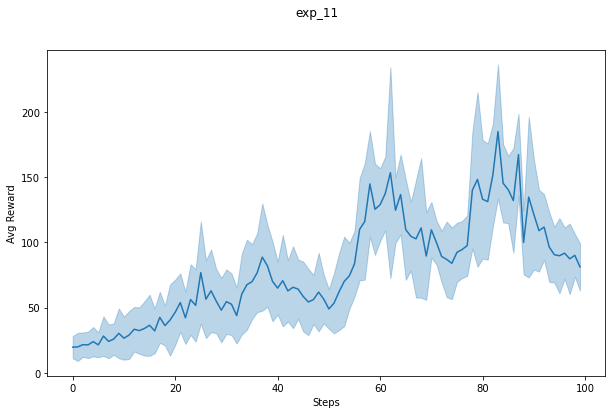

In [4]:
# join de experimentos
exp_11=exp_11_1_CartPole
for i in [exp_11_2_CartPole,exp_11_3_CartPole]:
    exp_11=exp_11.join(i)

# Promedio de experimentos
exp_11_mean=pd.DataFrame()
exp_11_mean["avg_reward"]=exp_11[["avg_reward1","avg_reward2","avg_reward3"]].mean(axis=1)
exp_11_mean["std_reward"]=exp_11[["std_reward1","std_reward2","std_reward3"]].mean(axis=1)
exp_11_mean.reset_index(inplace=True)
tr_steps_vec=exp_11_mean["steps"]
avg_reward_vec=exp_11_mean["avg_reward"]
std_reward_vec= exp_11_mean["std_reward"]

# Plot
_, (ax1) = plt.subplots(1, 1, figsize=(10,6))
ax1.plot(tr_steps_vec, avg_reward_vec, color='C0')
ax1.fill_between(tr_steps_vec, avg_reward_vec-std_reward_vec, avg_reward_vec+std_reward_vec, color='C0', alpha=0.3)
ax1.set_ylabel('Avg Reward')
ax1.set_xlabel('Steps')
plt.suptitle("exp_11")
plt.show()


# Exp 21

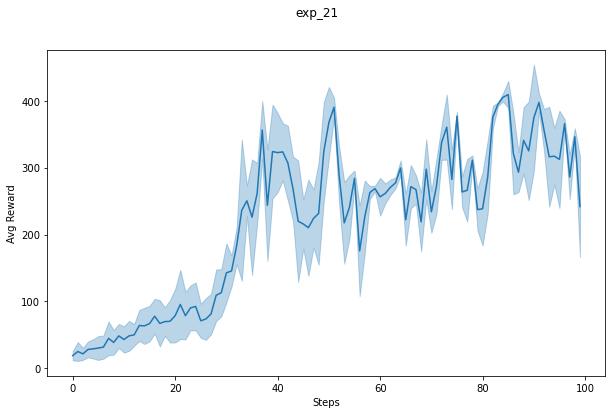

In [5]:
# join de experimentos
exp_21=exp_21_1_CartPole
for i in [exp_21_2_CartPole,exp_21_3_CartPole]:
    exp_21=exp_21.join(i)

# Promedio de experimentos
exp_21_mean=pd.DataFrame()
exp_21_mean["avg_reward"]=exp_21[["avg_reward1","avg_reward2","avg_reward3"]].mean(axis=1)
exp_21_mean["std_reward"]=exp_21[["std_reward1","std_reward2","std_reward3"]].mean(axis=1)
exp_21_mean.reset_index(inplace=True)
tr_steps_vec=exp_21_mean["steps"]
avg_reward_vec=exp_21_mean["avg_reward"]
std_reward_vec= exp_21_mean["std_reward"]

# Plot
_, (ax1) = plt.subplots(1, 1, figsize=(10,6))
ax1.plot(tr_steps_vec, avg_reward_vec, color='C0')
ax1.fill_between(tr_steps_vec, avg_reward_vec-std_reward_vec, avg_reward_vec+std_reward_vec, color='C0', alpha=0.3)
ax1.set_ylabel('Avg Reward')
ax1.set_xlabel('Steps')
plt.suptitle("exp_21")
plt.show()

# Exp 31

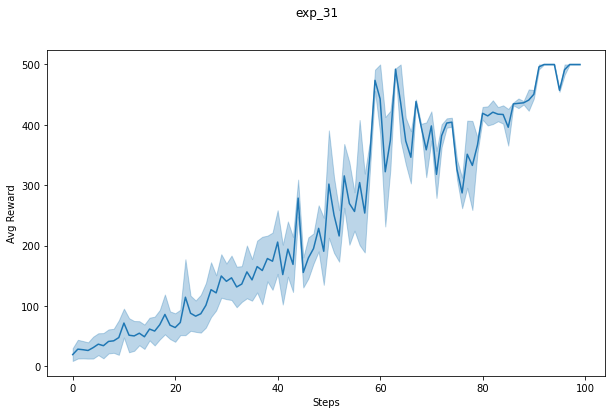

In [6]:
# join de experimentos
exp_31=exp_31_1_CartPole
for i in [exp_31_2_CartPole,exp_31_3_CartPole]:
    exp_31=exp_31.join(i)

# Promedio de experimentos
exp_31_mean=pd.DataFrame()
exp_31_mean["avg_reward"]=exp_31[["avg_reward1","avg_reward2","avg_reward3"]].mean(axis=1)
exp_31_mean["std_reward"]=exp_31[["std_reward1","std_reward2","std_reward3"]].mean(axis=1)
exp_31_mean.reset_index(inplace=True)
tr_steps_vec=exp_31_mean["steps"]
avg_reward_vec=exp_31_mean["avg_reward"]
std_reward_vec= exp_31_mean["std_reward"]

# Plot
_, (ax1) = plt.subplots(1, 1, figsize=(10,6))
ax1.plot(tr_steps_vec, avg_reward_vec, color='C0')
ax1.fill_between(tr_steps_vec, avg_reward_vec-std_reward_vec, avg_reward_vec+std_reward_vec, color='C0', alpha=0.3)
ax1.set_ylabel('Avg Reward')
ax1.set_xlabel('Steps')
plt.suptitle("exp_31")
plt.show()

# Exp 41

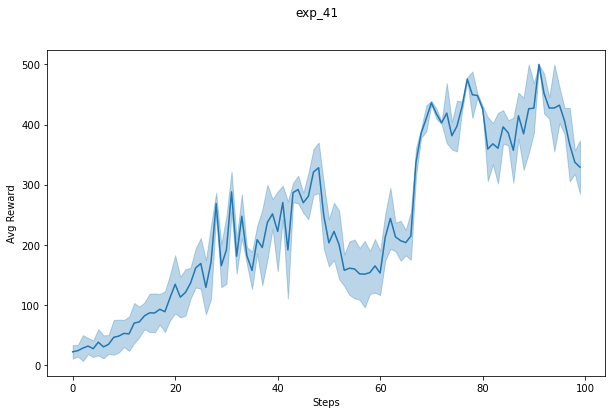

In [7]:
# join de experimentos
exp_41=exp_41_1_CartPole
for i in [exp_41_2_CartPole,exp_41_3_CartPole]:
    exp_41=exp_41.join(i)

# Promedio de experimentos
exp_41_mean=pd.DataFrame()
exp_41_mean["avg_reward"]=exp_41[["avg_reward1","avg_reward2","avg_reward3"]].mean(axis=1)
exp_41_mean["std_reward"]=exp_41[["std_reward1","std_reward2","std_reward3"]].mean(axis=1)
exp_41_mean.reset_index(inplace=True)
tr_steps_vec=exp_41_mean["steps"]
avg_reward_vec=exp_41_mean["avg_reward"]
std_reward_vec= exp_41_mean["std_reward"]

# Plot
_, (ax1) = plt.subplots(1, 1, figsize=(10,6))
ax1.plot(tr_steps_vec, avg_reward_vec, color='C0')
ax1.fill_between(tr_steps_vec, avg_reward_vec-std_reward_vec, avg_reward_vec+std_reward_vec, color='C0', alpha=0.3)
ax1.set_ylabel('Avg Reward')
ax1.set_xlabel('Steps')
plt.suptitle("exp_41")
plt.show()

# Exp 12

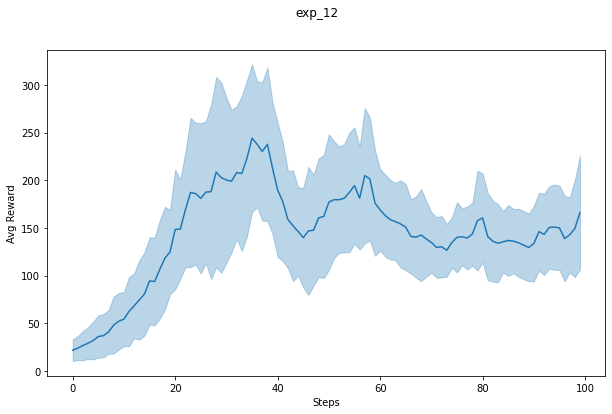

In [8]:
# join de experimentos
exp_12=exp_12_1_CartPole
for i in [exp_12_2_CartPole,exp_12_3_CartPole]:
    exp_12=exp_12.join(i)

# Promedio de experimentos
exp_12_mean=pd.DataFrame()
exp_12_mean["avg_reward"]=exp_12[["avg_reward1","avg_reward2","avg_reward3"]].mean(axis=1)
exp_12_mean["std_reward"]=exp_12[["std_reward1","std_reward2","std_reward3"]].mean(axis=1)
exp_12_mean.reset_index(inplace=True)
tr_steps_vec=exp_12_mean["steps"]
avg_reward_vec=exp_12_mean["avg_reward"]
std_reward_vec= exp_12_mean["std_reward"]

# Plot
_, (ax1) = plt.subplots(1, 1, figsize=(10,6))
ax1.plot(tr_steps_vec, avg_reward_vec, color='C0')
ax1.fill_between(tr_steps_vec, avg_reward_vec-std_reward_vec, avg_reward_vec+std_reward_vec, color='C0', alpha=0.3)
ax1.set_ylabel('Avg Reward')
ax1.set_xlabel('Steps')
plt.suptitle("exp_12")
plt.show()

# Exp 22

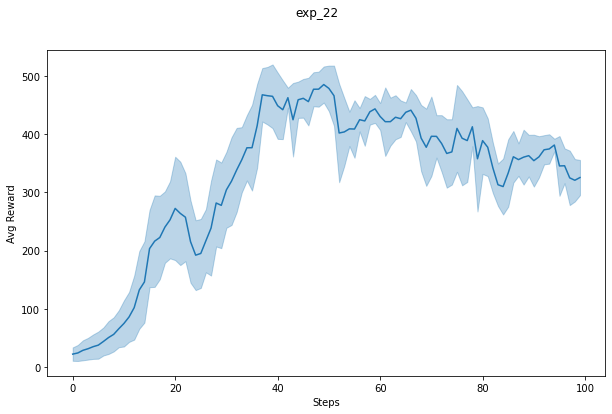

In [9]:
# join de experimentos
exp_22=exp_22_1_CartPole
for i in [exp_22_2_CartPole,exp_22_3_CartPole]:
    exp_22=exp_22.join(i)

# Promedio de experimentos
exp_22_mean=pd.DataFrame()
exp_22_mean["avg_reward"]=exp_22[["avg_reward1","avg_reward2","avg_reward3"]].mean(axis=1)
exp_22_mean["std_reward"]=exp_22[["std_reward1","std_reward2","std_reward3"]].mean(axis=1)
exp_22_mean.reset_index(inplace=True)
tr_steps_vec=exp_22_mean["steps"]
avg_reward_vec=exp_22_mean["avg_reward"]
std_reward_vec= exp_22_mean["std_reward"]

# Plot
_, (ax1) = plt.subplots(1, 1, figsize=(10,6))
ax1.plot(tr_steps_vec, avg_reward_vec, color='C0')
ax1.fill_between(tr_steps_vec, avg_reward_vec-std_reward_vec, avg_reward_vec+std_reward_vec, color='C0', alpha=0.3)
ax1.set_ylabel('Avg Reward')
ax1.set_xlabel('Steps')
plt.suptitle("exp_22")
plt.show()

# exp 32

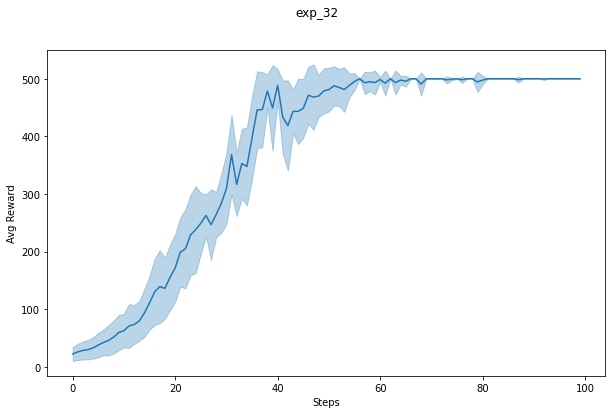

In [10]:
# join de experimentos
exp_32=exp_32_1_CartPole
for i in [exp_32_2_CartPole,exp_32_3_CartPole]:
    exp_32=exp_32.join(i)

# Promedio de experimentos
exp_32_mean=pd.DataFrame()
exp_32_mean["avg_reward"]=exp_32[["avg_reward1","avg_reward2","avg_reward3"]].mean(axis=1)
exp_32_mean["std_reward"]=exp_32[["std_reward1","std_reward2","std_reward3"]].mean(axis=1)
exp_32_mean.reset_index(inplace=True)
tr_steps_vec=exp_32_mean["steps"]
avg_reward_vec=exp_32_mean["avg_reward"]
std_reward_vec= exp_32_mean["std_reward"]

# Plot
_, (ax1) = plt.subplots(1, 1, figsize=(10,6))
ax1.plot(tr_steps_vec, avg_reward_vec, color='C0')
ax1.fill_between(tr_steps_vec, avg_reward_vec-std_reward_vec, avg_reward_vec+std_reward_vec, color='C0', alpha=0.3)
ax1.set_ylabel('Avg Reward')
ax1.set_xlabel('Steps')
plt.suptitle("exp_32")
plt.show()

# Exp 42

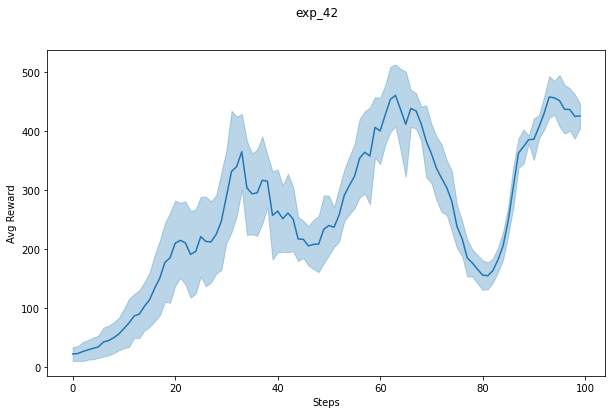

In [11]:
# join de experimentos
exp_42=exp_42_1_CartPole
for i in [exp_42_2_CartPole,exp_42_3_CartPole]:
    exp_42=exp_42.join(i)

# Promedio de experimentos
exp_42_mean=pd.DataFrame()
exp_42_mean["avg_reward"]=exp_42[["avg_reward1","avg_reward2","avg_reward3"]].mean(axis=1)
exp_42_mean["std_reward"]=exp_42[["std_reward1","std_reward2","std_reward3"]].mean(axis=1)
exp_42_mean.reset_index(inplace=True)
tr_steps_vec=exp_42_mean["steps"]
avg_reward_vec=exp_42_mean["avg_reward"]
std_reward_vec= exp_42_mean["std_reward"]

# Plot
_, (ax1) = plt.subplots(1, 1, figsize=(10,6))
ax1.plot(tr_steps_vec, avg_reward_vec, color='C0')
ax1.fill_between(tr_steps_vec, avg_reward_vec-std_reward_vec, avg_reward_vec+std_reward_vec, color='C0', alpha=0.3)
ax1.set_ylabel('Avg Reward')
ax1.set_xlabel('Steps')
plt.suptitle("exp_42")
plt.show()

**Pendulum**

In [12]:
exp_12_1_Pendulum=pd.read_csv("exp_12_1_Pendulum.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward1","std_reward":"std_reward1"})
exp_12_2_Pendulum=pd.read_csv("exp_12_2_Pendulum.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward2","std_reward":"std_reward2"})
exp_12_3_Pendulum=pd.read_csv("exp_12_3_Pendulum.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward3","std_reward":"std_reward3"})

exp_22_1_Pendulum=pd.read_csv("exp_22_1_Pendulum.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward1","std_reward":"std_reward1"})
exp_22_2_Pendulum=pd.read_csv("exp_22_2_Pendulum.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward2","std_reward":"std_reward2"})
exp_22_3_Pendulum=pd.read_csv("exp_22_3_Pendulum.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward3","std_reward":"std_reward3"})

exp_32_1_Pendulum=pd.read_csv("exp_32_1_Pendulum.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward1","std_reward":"std_reward1"})
exp_32_2_Pendulum=pd.read_csv("exp_32_2_Pendulum.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward2","std_reward":"std_reward2"})
exp_32_3_Pendulum=pd.read_csv("exp_32_3_Pendulum.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward3","std_reward":"std_reward3"})

exp_42_1_Pendulum=pd.read_csv("exp_42_1_Pendulum.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward1","std_reward":"std_reward1"})
exp_42_2_Pendulum=pd.read_csv("exp_42_2_Pendulum.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward2","std_reward":"std_reward2"})
exp_42_3_Pendulum=pd.read_csv("exp_42_3_Pendulum.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward3","std_reward":"std_reward3"})

# Exp 12

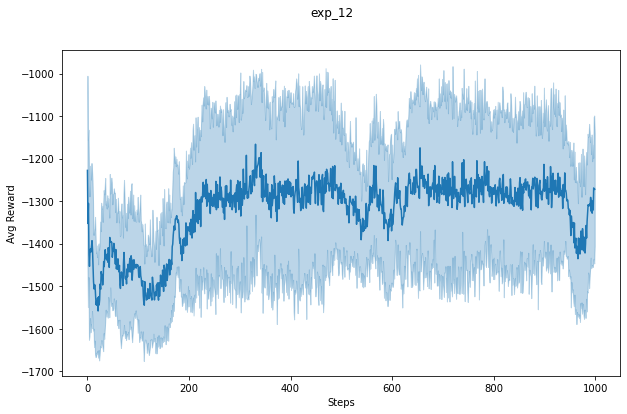

In [13]:
# join de experimentos
exp_12=exp_12_1_Pendulum
for i in [exp_12_2_Pendulum,exp_12_3_Pendulum]:
    exp_12=exp_12.join(i)

# Promedio de experimentos
exp_12_mean=pd.DataFrame()
exp_12_mean["avg_reward"]=exp_12[["avg_reward1","avg_reward2","avg_reward3"]].mean(axis=1)
exp_12_mean["std_reward"]=exp_12[["std_reward1","std_reward2","std_reward3"]].mean(axis=1)
exp_12_mean.reset_index(inplace=True)
tr_steps_vec=exp_12_mean["steps"]
avg_reward_vec=exp_12_mean["avg_reward"]
std_reward_vec= exp_12_mean["std_reward"]

# Plot
_, (ax1) = plt.subplots(1, 1, figsize=(10,6))
ax1.plot(tr_steps_vec, avg_reward_vec, color='C0')
ax1.fill_between(tr_steps_vec, avg_reward_vec-std_reward_vec, avg_reward_vec+std_reward_vec, color='C0', alpha=0.3)
ax1.set_ylabel('Avg Reward')
ax1.set_xlabel('Steps')
plt.suptitle("exp_12")
plt.show()

# Exp 22

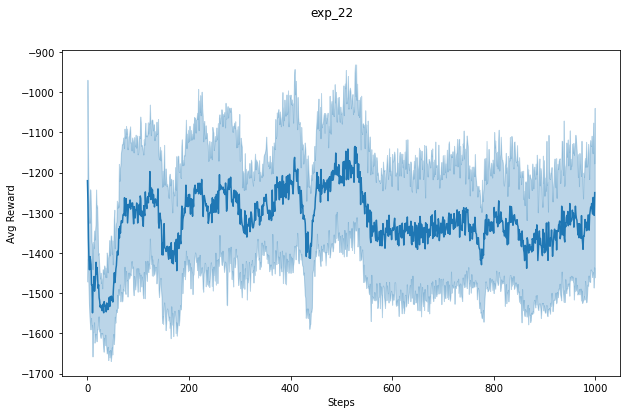

In [14]:
# join de experimentos
exp_22=exp_22_1_Pendulum
for i in [exp_22_2_Pendulum,exp_22_3_Pendulum]:
    exp_22=exp_22.join(i)

# Promedio de experimentos
exp_22_mean=pd.DataFrame()
exp_22_mean["avg_reward"]=exp_22[["avg_reward1","avg_reward2","avg_reward3"]].mean(axis=1)
exp_22_mean["std_reward"]=exp_22[["std_reward1","std_reward2","std_reward3"]].mean(axis=1)
exp_22_mean.reset_index(inplace=True)
tr_steps_vec=exp_22_mean["steps"]
avg_reward_vec=exp_22_mean["avg_reward"]
std_reward_vec= exp_22_mean["std_reward"]

# Plot
_, (ax1) = plt.subplots(1, 1, figsize=(10,6))
ax1.plot(tr_steps_vec, avg_reward_vec, color='C0')
ax1.fill_between(tr_steps_vec, avg_reward_vec-std_reward_vec, avg_reward_vec+std_reward_vec, color='C0', alpha=0.3)
ax1.set_ylabel('Avg Reward')
ax1.set_xlabel('Steps')
plt.suptitle("exp_22")
plt.show()

# Exp 32

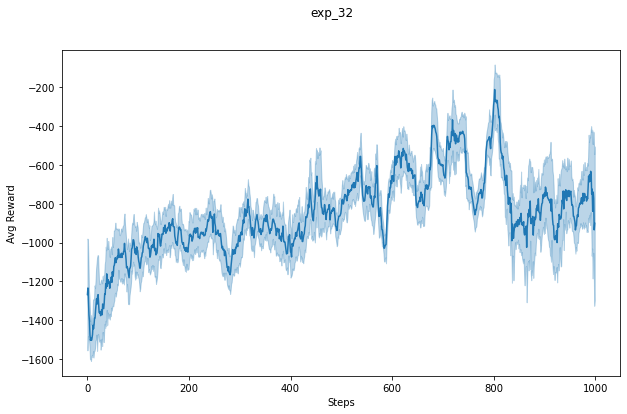

In [15]:
# join de experimentos
exp_32=exp_32_1_Pendulum
for i in [exp_32_2_Pendulum,exp_32_3_Pendulum]:
    exp_32=exp_32.join(i)

# Promedio de experimentos
exp_32_mean=pd.DataFrame()
exp_32_mean["avg_reward"]=exp_32[["avg_reward1","avg_reward2","avg_reward3"]].mean(axis=1)
exp_32_mean["std_reward"]=exp_32[["std_reward1","std_reward2","std_reward3"]].mean(axis=1)
exp_32_mean.reset_index(inplace=True)
tr_steps_vec=exp_32_mean["steps"]
avg_reward_vec=exp_32_mean["avg_reward"]
std_reward_vec= exp_32_mean["std_reward"]

# Plot
_, (ax1) = plt.subplots(1, 1, figsize=(10,6))
ax1.plot(tr_steps_vec, avg_reward_vec, color='C0')
ax1.fill_between(tr_steps_vec, avg_reward_vec-std_reward_vec, avg_reward_vec+std_reward_vec, color='C0', alpha=0.3)
ax1.set_ylabel('Avg Reward')
ax1.set_xlabel('Steps')
plt.suptitle("exp_32")
plt.show()

# Exp 42

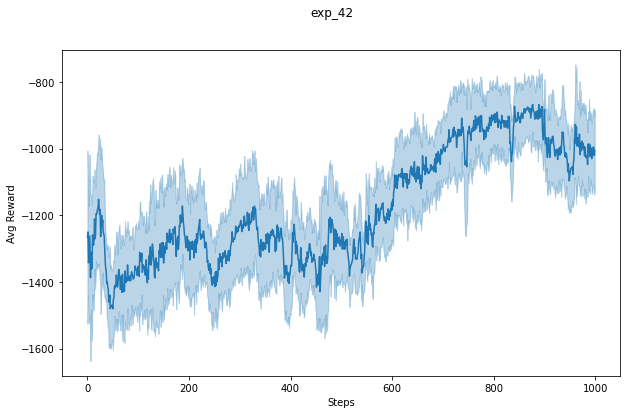

In [16]:
# join de experimentos
exp_42=exp_42_1_Pendulum
for i in [exp_42_2_Pendulum,exp_42_3_Pendulum]:
    exp_42=exp_42.join(i)

# Promedio de experimentos
exp_42_mean=pd.DataFrame()
exp_42_mean["avg_reward"]=exp_42[["avg_reward1","avg_reward2","avg_reward3"]].mean(axis=1)
exp_42_mean["std_reward"]=exp_42[["std_reward1","std_reward2","std_reward3"]].mean(axis=1)
exp_42_mean.reset_index(inplace=True)
tr_steps_vec=exp_42_mean["steps"]
avg_reward_vec=exp_42_mean["avg_reward"]
std_reward_vec= exp_42_mean["std_reward"]

# Plot
_, (ax1) = plt.subplots(1, 1, figsize=(10,6))
ax1.plot(tr_steps_vec, avg_reward_vec, color='C0')
ax1.fill_between(tr_steps_vec, avg_reward_vec-std_reward_vec, avg_reward_vec+std_reward_vec, color='C0', alpha=0.3)
ax1.set_ylabel('Avg Reward')
ax1.set_xlabel('Steps')
plt.suptitle("exp_42")
plt.show()